In [1]:
'''
University of São Paulo - USP
Institute of Mathematical and Computer Sciences - ICMC
Distributed Systems and Concurrent Programming Laboratory - LaSDPC

Authors: Vinícius Aires Barros
         Leonardo Beck Prates
         Sarita Mazzini Bruschi
         Júlio Cezar Estrella
'''

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import json
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (8.0, 10.0)

In [2]:
#CPU and Memory Usage
fname_pgsql = "results/with-monitoring/pgsql/osquery/osqueryd.results.pgsql.log"
fname_mongo = "results/with-monitoring/mongo/osquery/osqueryd.results.mongo.log"

In [3]:
def plot_cpu_usage(json_objs_arr, fName):
    cpu_usage = {'0':[],'1':[],'2':[],'3':[],'4':[],'5':[],'6':[],'7':[]}
    json_names = ['guest', 'guest_nice', 'idle', 'iowait', 'irq', 'nice', 'softirq', 'steal', 'system', 'user']
    
    for num_core in range(0, 8):
        prev_total = 0
        prev_idle = 0
        for json_obj in json_objs_arr:
            if(int(json_obj['columns']['core']) == num_core):
                values = [int(json_obj['columns'][x]) for x in json_names]
                total = np.sum(values)
                diff_idle = values[2] - prev_idle
                diff_total = total - prev_total
                diff_usage = ((1000 * (diff_total - diff_idle) / (diff_total + 5))/10)
                cpu_usage[json_obj['columns']['core']].append(float("%.2f"%diff_usage))
                prev_total = total
                prev_idle = values[2]

        index = 1
        for key, values in cpu_usage.items():
            axes = plt.subplot(int("42{}".format(index)))
            index += 1
            plt.plot(values, '-r', c='#26A69A')
            plt.ylabel("Percentage (%)")
            plt.title("CPU {}".format(key))

    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.savefig("charts/pdf/" + fName + ".pdf", bbox_inches='tight', dpi=100)
    plt.savefig("charts/png/" + fName + ".png", bbox_inches='tight', dpi=100)
    plt.show()
    
def plot_memory_usage(memory_usage_grouped, dbName, fName, sub_plot=211):
    
    for memory_usage, db in zip(memory_usage_grouped, dbName):
        ax = plt.subplot(sub_plot)
        ax.set_ylim([0,100])
        plt.plot([i for i in range(0, len(memory_usage[0]))], memory_usage[0], '--r', c='r', label='Main Memory')
        plt.plot([i for i in range(0, len(memory_usage[1]))], memory_usage[1], '-r', c='b', label='Swap Memory')
        plt.legend(loc=5, borderaxespad=0.5)
        plt.ylabel("Percentage (%)")
        plt.title(db)
        sub_plot += 1
        
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.savefig("charts/pdf/" + fName + ".pdf", bbox_inches='tight', dpi=100)
    plt.savefig("charts/png/" + fName + ".png", bbox_inches='tight', dpi=100)
    plt.show()
    
def show_memory_avg_info(memory_usage):
    avg_memory_pgsql = np.mean(memory_usage[0])    
    avg_memory_mongo = np.mean(memory_usage[1])
    diff_memory = max(avg_memory_pgsql, avg_memory_mongo) - min(avg_memory_pgsql, avg_memory_mongo)
    print("PostgreSQL Memory Usage: %.2f%%"%np.mean(memory_usage_pgsql))
    print("Mongo Memory Usage: %.2f%%"%np.mean(memory_usage_mongo))
    print("Diff Memory Usage: %.2f%%"%diff_memory)


def memory_percentage(memory_total, memory_free):
    return (((memory_total - memory_free) * 100)/memory_total)

def show_cpu_avg_info(json_objs_arr):
    cpu_usage = []
    json_names = ['guest', 'guest_nice', 'idle', 'iowait', 'irq', 'nice', 'softirq', 'steal', 'system', 'user']
    
    for num_core in range(0, 8):
        prev_total = 0
        prev_idle = 0
        for json_obj in json_objs_arr:
            if(int(json_obj['columns']['core']) == num_core):
                values = [int(json_obj['columns'][x]) for x in json_names]
                total = np.sum(values)
                diff_idle = values[2] - prev_idle
                diff_total = total - prev_total
                diff_usage = ((1000 * (diff_total - diff_idle) / (diff_total + 5))/10)
                cpu_usage.append(float("%.2f"%diff_usage))
                prev_total = total
                prev_idle = values[2]
    return np.mean(cpu_usage), drop_zeros(cpu_usage)

def drop_zeros(data_input):
    data_output = []
    for value in data_input:
        if value > 0:
            data_output.append(value)
    return data_output

In [4]:
plt.rcParams.update({'font.size': 11})

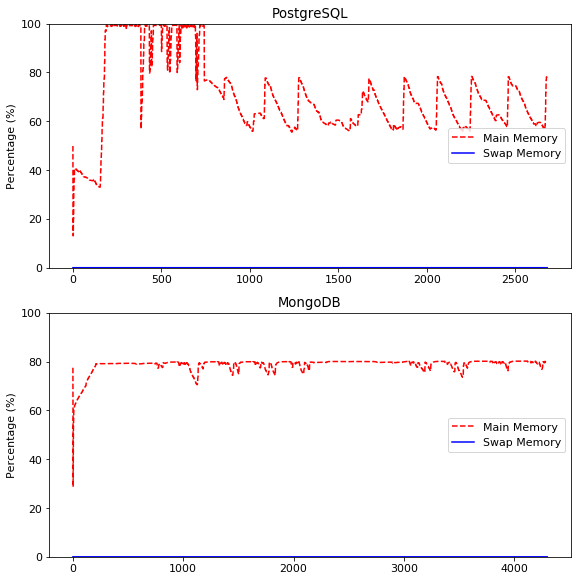

In [5]:
with open(fname_pgsql) as file:
    pgsql_log_content = file.readlines()
    
with open(fname_mongo) as file:
    mongo_log_content = file.readlines()
    
pgsql_log_content = [x.strip() for x in pgsql_log_content]
pgsql_log_content_memory_info = [row for row in pgsql_log_content if not '\"name\":\"cpu_info\"' in row]
pgsql_log_content_cpu_info = [row for row in pgsql_log_content if not '\"name\":\"memory_info\"' in row]

mongo_log_content = [x.strip() for x in mongo_log_content]
mongo_log_content_memory_info = [row for row in mongo_log_content if not '\"name\":\"cpu_info\"' in row]
mongo_log_content_cpu_info = [row for row in mongo_log_content if not '\"name\":\"memory_info\"' in row]

#PgSQL Memory Usage
pgsql_json_objs_arr = [json.loads(json_str) for json_str in pgsql_log_content_memory_info]
memory_usage_pgsql = [memory_percentage(int(json_obj['columns']['memory_total']), int(json_obj['columns']['memory_free'])) for json_obj in pgsql_json_objs_arr]
swap_usage_pgsql = [memory_percentage(int(json_obj['columns']['swap_total']), int(json_obj['columns']['swap_free'])) for json_obj in pgsql_json_objs_arr]

#MongoDB Memory Usage
mongo_json_objs_arr = [json.loads(json_str) for json_str in mongo_log_content_memory_info]
memory_usage_mongo = [memory_percentage(int(json_obj['columns']['memory_total']), int(json_obj['columns']['memory_free'])) for json_obj in mongo_json_objs_arr]
swap_usage_mongo = [memory_percentage(int(json_obj['columns']['swap_total']), int(json_obj['columns']['swap_free'])) for json_obj in mongo_json_objs_arr]

plt.rcParams['figure.figsize'] = (8.0, 8.0)
memory_usage_grouped = [[memory_usage_pgsql, swap_usage_pgsql],[memory_usage_mongo, swap_usage_mongo]]
plot_memory_usage(memory_usage_grouped, ["PostgreSQL", "MongoDB"], "memory_usage_30")

In [6]:
show_memory_avg_info([memory_usage_pgsql, memory_usage_mongo])

PostgreSQL Memory Usage: 70.12%
Mongo Memory Usage: 78.64%
Diff Memory Usage: 8.51%


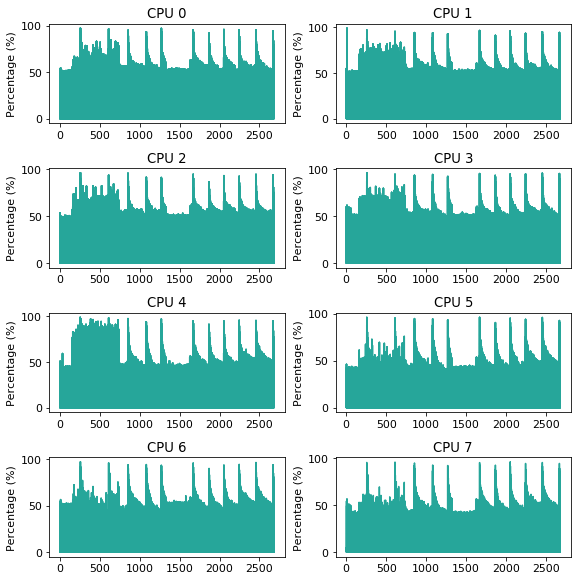

In [7]:
#PgSQL CPU Usage
pgsql_json_objs_arr = [json.loads(json_str) for json_str in pgsql_log_content_cpu_info]
plot_cpu_usage(pgsql_json_objs_arr, "cpu_usage_pgsql_cpu_30")

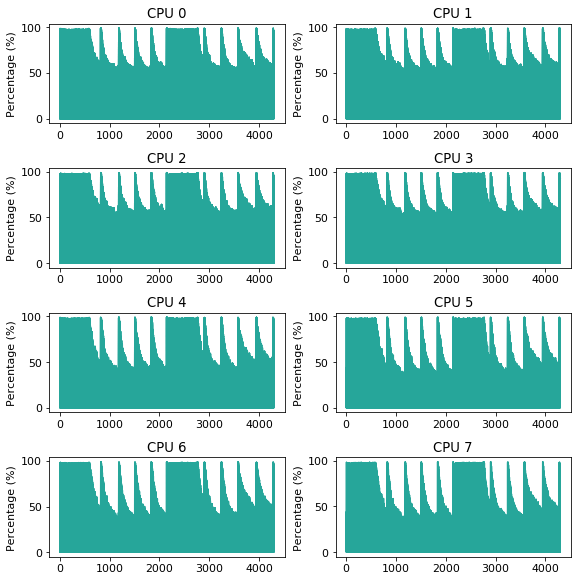

In [8]:
#MongoDB CPU Usage
mongo_json_objs_arr = [json.loads(json_str) for json_str in mongo_log_content_cpu_info]
plot_cpu_usage(mongo_json_objs_arr, "cpu_usage_mongo_cpu_30")

In [9]:
mean_cpu_pgsql, cpu_usage_pgsql = show_cpu_avg_info(pgsql_json_objs_arr)

In [10]:
mean_cpu_mongo, cpu_usage_mongo = show_cpu_avg_info(mongo_json_objs_arr)

In [11]:
diff_mean = (max(mean_cpu_mongo, mean_cpu_pgsql) - min(mean_cpu_mongo, mean_cpu_pgsql))

print("PgSQL CPU Usage (%)")
print("Avg PgSQL: %.2f%%"%mean_cpu_pgsql)
print("Min PgSQL: %.2f%%"%min(cpu_usage_pgsql))
print("Max PgSQL: %.2f%%"%max(cpu_usage_pgsql))
print("Median PgSQL: %.2f%%"%np.median(cpu_usage_pgsql))
print("STD PgSQL: %.2f%%"%np.std(cpu_usage_pgsql))

print("-"*20)

print("PgSQL CPU Usage (%)")
print("Avg MongoDB: %.2f%%"%mean_cpu_mongo)
print("Min MongoDB: %.2f%%"%min(cpu_usage_mongo))
print("Max MongoDB: %.2f%%"%max(cpu_usage_mongo))
print("Median MongoDB: %.2f%%"%np.median(cpu_usage_mongo))
print("STD Mongo: %.2f%%"%np.std(cpu_usage_mongo))

print("-"*20)
print("Diff CPU Usage: %.2f%%"%(mean_cpu_mongo-mean_cpu_pgsql))

PgSQL CPU Usage (%)
Avg PgSQL: 28.12%
Min PgSQL: 0.40%
Max PgSQL: 99.10%
Median PgSQL: 54.08%
STD PgSQL: 11.27%
--------------------
PgSQL CPU Usage (%)
Avg MongoDB: 35.71%
Min MongoDB: 0.01%
Max MongoDB: 98.92%
Median MongoDB: 66.19%
STD Mongo: 20.49%
--------------------
Diff CPU Usage: 7.59%
